In [1]:
from glob import glob
from time import time
import os, cv2, copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from reader import readShortVideo, getVideoList
from utils import showFrames

# 1. import the table contains video and label info.

In [ ]:
task = 'train'
path = './hw4_data/TrimmedVideos/'

train_table = pd.read_csv(os.path.join(path,'label/gt_'+task+'.csv'))
train_table.head(3)

# 2. load training data and label

In [ ]:
# train data
video_path = './hw4_data/TrimmedVideos/video/'+task+'/'
train_x = []
train_y = []

for idx, value in train_table[['Video_category', 'Video_name', 'Action_labels']].iterrows() :
    
    video_category = value.Video_category
    video_name = value.Video_name

    def custom_VideoNameExtractor(video_path, video_category, video_name):
        video_name = glob(os.path.join(video_path, video_category, video_name)+'*')[0]
        video_name = video_name.split('/')[-1]
        return video_name
    video_name = custom_VideoNameExtractor(video_path, video_category, video_name)
    
    try:
        
        frames =  readShortVideo(video_path=video_path, 
                                 video_category=video_category, 
                                 video_name = video_name)
        train_x.append(frames / 255)
        train_y.append(value.Action_labels)
    except Exception as e:
        print(e)
        
    if (idx+1) % 100 == 0 :
        print("[INFO] loading progress, (%s/%s)" % ((idx+1), len(train_table)))
    
    
print("[INFO] load train_x successfully, train_x length :", len(train_x))

# load pretrained model

In [ ]:
import torch
from torch.autograd import Variable
from torch import nn
from torch import optim

In [ ]:
# Multi Frame VGG model
class MFrnnVGG(nn.Module):
    def __init__(self, backend='vgg16', pretrained=True, n_label=11):
        super(MFrnnVGG, self).__init__()
        
        ### check valid 
        if backend in ['vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn']:
            pass
        else :
            print("[INFO] invalid backend '%s', change to 'vgg16_bn'" % backend)
            backend = 'vgg16_bn'
            
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        ### init param
        self.backend = backend
        self.pretrained = pretrained
        # model flow
        self.features = None
        self.avgpool = None
        self.RNN = None
        self.h0 = None # follow RNN
        self.c0 = None # follow RNN
        self.classifier = None
        
        ### init process
        self.load_pretrained() # load features
        self.create_RNN() # create RNN 
        self.create_classifier(n_label) # create last layer
        self.fix_features() # fix features weights
        
    def forward(self, input):
        '''
        input shape : (frame, channel, height, weight)
        output shape : (1, cls)
        '''
        f, c, h, w = input.shape
        
        # regard f:frames as b:batch
        x = self.features(input) # shape : (f, 512, 7, 10)
        x = self.avgpool(x) # shape (f, 512, 7, 7)      
        
        x = torch.flatten(x, start_dim=1) # (f, 25088)
        x = torch.unsqueeze(x,0) # (1, f, 25088)
        
        out, h = self.RNN(x, self.h0) # out(1, f, 1024) & (num_layers=1, 1, 1024)
        x = torch.squeeze(h, 0) # (1, 1024)        
        
        x = self.classifier(x) # out shape : (1, 11)
        return x
    
    def load_pretrained(self):
        import torchvision.models as models
        backend_model = None
        try:
            if self.backend == 'vgg13' :
                backend_model = models.vgg13(pretrained=self.pretrained)
            elif self.backend == 'vgg13_bn' :
                backend_model = models.vgg13_bn(pretrained=self.pretrained)
            elif self.backend == 'vgg16' :
                backend_model = models.vgg16(pretrained=self.pretrained)
            elif self.backend == 'vgg16_bn':
                backend_model = models.vgg16_bn(pretrained=self.pretrained)
            
            
            else :
                raise ValueError("[ERROR] Unexpected backend name pass through previous check then into load_pretrained() .")
            # copy features flow
            self.features = copy.deepcopy(backend_model.features) 
            self.avgpool = copy.deepcopy(backend_model.avgpool)
            print("[INFO] load pretrained features successfully, backend : %s" % self.backend)
        except Exception as e:
            print(e)
    
    def create_RNN(self, rnn='GRU', hidden_size=1024, num_layers=1, batch_first=True):
        '''
        output (batch, seq, hidden_size)
        h_out (n_layer, batch, hidden_size)
        '''
        try:
            input_size = None
            if self.backend in ['vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn']:
                input_size = 25088
            else :
                raise ValueError("[ERROR] Unexpected backend name pass through previous check then into create_outLayer() .")
            
            if rnn == 'GRU' :
                self.RNN = nn.GRU(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    num_layers=num_layers, 
                    batch_first=batch_first,
                )
                self.h0 = Variable(torch.zeros((num_layers,1,hidden_size)), requires_grad=False).to(self.device) # bach_size = 1
            
            else :
                raise ValueError("[ERROR] Unexpected rnn '%s', please select one in ['GRU']" & rnn)
                
            print("[INFO] create RNN component successfully, rnn : %s ." % rnn)
        except Exception as e:
            print(e)
        
        
    def create_classifier(self, n_label=11):
        try:
            if self.backend in ['vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn'] :
                self.classifier = nn.Sequential(
                    nn.Linear(1024, 1024),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(1024, 11),
                    nn.Softmax(),
                )
            else :
                raise ValueError("[ERROR] Unexpected backend name pass through previous check then into create_outLayer() .")
        
            print("[INFO] create classifier successfully.")
        except Exception as e:
            print(e)
                
    def fix_features(self): # fix features weights
        for param in self.features.parameters():
            param.requires_grad = False


model = MFrnnVGG(backend='vgg13_bn')

# train model

In [ ]:
# GPU is useless when batch size = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch import FloatTensor, LongTensor


epochs = 200
lr=1e-3

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(list(model.RNN.parameters()) + list(model.classifier.parameters()), lr=lr)

model.to(device)
# model.h0.to(device)


#################### history ####################
history = {}
history['loss'] = []
history['acc'] = []

history['err'] = {}
history['err']['epoch'] = []
history['err']['err_idx'] = []
history['err']['err_msg'] = []
#################################################

for epoch in range(epochs):
    start_time = time()
    total_loss = 0.
    acc = 0.
    cnt = 0
    
    for idx, (x, y) in enumerate(zip(train_x, train_y)):
        x = np.transpose(x, (0,3,1,2)) # transpose for torch input : shape (f, 240, 320, 3) --> (f, 3, 240, 320)
        y = np.array([y]) # shape (1,)
        
        try: 
            x = Variable(FloatTensor(x)).to(device)
            y = Variable(LongTensor(y)).to(device)

            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            acc += 1. if pred.argmax().item() == y.item() else 0.
            total_loss += loss.item()
            cnt += 1
        except Exception as e:
            history['err']['epoch'].append(epoch)
            history['err']['err_idx'].append(idx)
            history['err']['err_msg'].append(str(e))

    history['loss'].append(total_loss/cnt)
    history['acc'].append((100*acc)/cnt)
    print('[INFO] epoch (%d/%d), cost: %d sec | loss : %.6f | acc : %.2f%%' % (epoch, epochs, (time()-start_time), (total_loss/cnt), (100*acc/cnt)))


In [ ]:
torch.save(model.classifier.state_dict(), './storage/MFrnnVGG_classifier.pkl')
torch.save(model.RNN.state_dict(), './storage/MFrnnVGG_RNN.pkl')

In [ ]:
import pickle


with open('./storage/history_p2_MFrnnVGG_vgg13bn_epoch200', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# eval and report

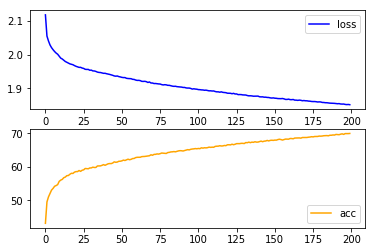

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

history = None
with open('./storage/history_p2_FVrnnVGG_vgg13bn_epoch200', 'rb') as file:
    history = pickle.load(file)
    
    
fig, (ax0, ax1) = plt.subplots(nrows=2)
# plot loss and acc
loss = history['loss']
acc = history['acc']
acc = np.array(acc)
acc += 0.11

x = np.arange(len(loss))

ax0.plot(x, loss, c='b')
ax0.legend(['loss'], loc='upper right')
ax1.plot(x, acc, c='orange')
ax1.legend(['acc'], loc='lower right')

# plt.legend(['loss'], loc='upper right')
plt.show()

## check validation result

In [3]:
import pandas as pd
import numpy as np
import os

In [4]:
# load label
task = 'valid'
path = './hw4_data/TrimmedVideos/'

table = pd.read_csv(os.path.join(path,'label/gt_'+task+'.csv'))
label = table['Action_labels']
len(label)


# load pred
pred = []
with open('./output/p2_result.txt', 'r') as file:
    for line in file:
        pred.append(int(line.replace('\n','')))
len(pred)

# eval
(np.array(label) == np.array(pred)).sum() / len(pred)

0.15604681404421328

## visual 


In [5]:
task = 'valid'
path = './hw4_data/TrimmedVideos/'

train_table = pd.read_csv(os.path.join(path,'label/gt_'+task+'.csv'))
train_table.head(3)


video_path = './hw4_data/TrimmedVideos/video/'+task+'/'
train_x = []
train_y = []

for idx, value in train_table[['Video_category', 'Video_name', 'Action_labels']].iterrows() :
    
    video_category = value.Video_category
    video_name = value.Video_name

    def custom_VideoNameExtractor(video_path, video_category, video_name):
        video_name = glob(os.path.join(video_path, video_category, video_name)+'*')[0]
        video_name = video_name.split('/')[-1]
        return video_name
    video_name = custom_VideoNameExtractor(video_path, video_category, video_name)
    
    try:
        
        frames =  readShortVideo(video_path=video_path, 
                                 video_category=video_category, 
                                 video_name = video_name)
        train_x.append(frames / 255)
        train_y.append(value.Action_labels)
    except Exception as e:
        print(e)
        
    if (idx+1) % 100 == 0 :
        print("[INFO] loading progress, (%s/%s)" % ((idx+1), len(train_table)))
    
print("[INFO] load train_x successfully, train_x length :", len(train_x))

[INFO] loading progress, (100/769)
[INFO] loading progress, (200/769)
[INFO] loading progress, (300/769)
[INFO] loading progress, (400/769)
[INFO] loading progress, (500/769)
[INFO] loading progress, (600/769)
[INFO] loading progress, (700/769)
[INFO] load train_x successfully, train_x length : 769


In [6]:
# load model

from model.MFrnnVGG import MFrnnVGG
import torch
model = MFrnnVGG(backend='vgg13_bn')
model.load_train_pretrain()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

[INFO] load pretrained features successfully, backend : vgg13_bn
[INFO] create RNN component successfully, rnn : GRU .
[INFO] create classifier successfully.
[INFO] load train pretrained weight successfully.


MFrnnVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(

In [7]:
from torch import FloatTensor
from torch.autograd import Variable

features = []
ys = []
model.cuda()
for idx, (x,y) in enumerate(zip(train_x, train_y)):
    try:
        x = np.transpose(x, (0,3,1,2))
        x = Variable(FloatTensor(x)).cuda()
        x = model.features(x)
        
        x = model.avgpool(x) # shape (f, 512, 7, 7)  
        x = torch.flatten(x, start_dim=1)
        x = torch.mean(x, 0, keepdim=True) # (1, 25088)
        x = torch.squeeze(x, 0) # (25088)
        
        x = x.cpu()
        features.append(torch.squeeze(x,0).detach().numpy())
        ys.append(y)
    except Exception as e:
        print(idx, e)
#     if idx > 100:
#         break


features = np.array(features)
ys = np.array(ys)

In [8]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


X_embedded = PCA(n_components=100).fit_transform(features)
X_embedded = TSNE(n_components=2).fit_transform(X_embedded)
X_embedded.shape

(769, 2)

10 list index out of range


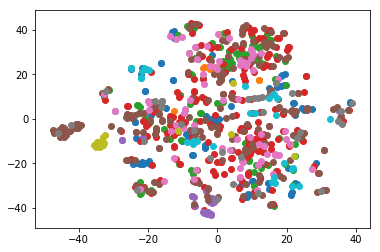

In [9]:
cmap = ['C0','C1','C2','C3','C4','C5', 'C6','C7','C8','C9']

for label in range(0,11):
    try:
        selected_data = X_embedded[np.where(ys == label)]
        plt.scatter(selected_data[:,0], selected_data[:,1], c=cmap[label])
    except Exception as e:
        print(label, e)
plt.show()